In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import torch.distributions as Di
import numpy as np
import math
from torch.utils.data import Dataset
from torch.nn import functional as F

In [2]:
m = []
for i in range(0,8):
  val = ((2 * np.pi * i)  * 0.125)
  mean = [2*math.cos(val), 2*math.sin(val)]
  m.append(mean)

In [3]:
w = torch.tensor([0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125])
means = torch.tensor(m)
std = torch.tensor([[0.02, 0.02] , [0.02,0.02], [0.02,0.02], [0.02,0.02] , [0.02,0.02], [0.02,0.02], [0.02,0.02], [0.02,0.02]])
mix = Di.Categorical(w)
comp = Di.Independent(Di.Normal(means,std), 1)
gmm1 = Di.MixtureSameFamily(mix, comp)

In [4]:
x = torch.empty(20000,2)
for i in range(0,20000):
  x[i] = gmm1.sample()


  

In [5]:
h_dim = 400
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            # z [b, 2] => [b, 2]
            # first 2 is arbitrary
            nn.Linear(2, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 2),
            # final 2 is intended for 2D visualization
        )

    def forward(self, z):
        output = self.net(z)
        return output

In [6]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
            # output probability (1, real data, 0 generated data)
        )

    def forward(self, x):
        output = self.net(x)
        return output.reshape(-1)


In [7]:
train_loader_real = torch.utils.data.DataLoader(dataset=x,batch_size=100,shuffle=True)

In [8]:
real_targets = torch.ones(100).cuda()
fake_targets = torch.zeros(512).cuda()

In [9]:
import matplotlib.pyplot as plt

def draw( data ) :    
    plt.figure()
    d = data.tolist() if isinstance(data, torch.Tensor ) else data
    plt.plot( d ) 
    plt.show()

In [ ]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5,0.9))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5,0.9))
real_targets_2 = torch.ones(512).cuda()
num_epochs = 2000
criterion = nn.BCELoss()
d_losses = []
g_losses = []
generated = []
for i in range(num_epochs):

  for x in train_loader_real:
    #Discriminator with real inputs
    #print(x.shape)
    x =x.cuda()
    d_out = discriminator(x)
    d_loss = criterion(d_out , real_targets)


    #generating images

    generator.eval()
    with torch.no_grad():
        z = torch.randn(512,2).cuda()
        gen_data = generator(z)
    
    d_output = discriminator(gen_data)
    d_loss += criterion(d_output, fake_targets) 
    
    #updating optimizers

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    #generatator training  
    generator.train()
    z = torch.randn(512,2).cuda()
    generated_gmm = generator(z)

    

    g_output = discriminator(generated_gmm)
    g_loss = criterion(g_output, real_targets_2)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())




  if i%1000 == 0:
    print(g_loss)
    print(d_loss)
    print(generated_gmm.shape)  









tensor(1.1180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2703, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([512, 2])


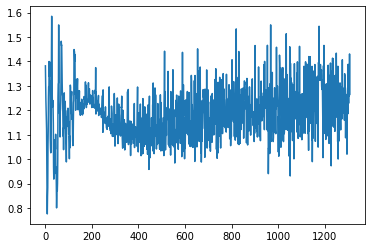

In [12]:
plt.plot(d_losses, label='d_losses')

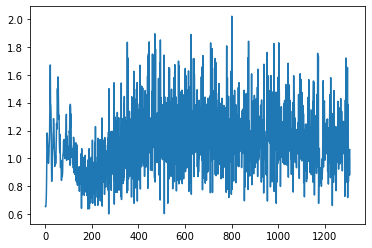

In [13]:
plt.plot(g_losses, label='g_losses')

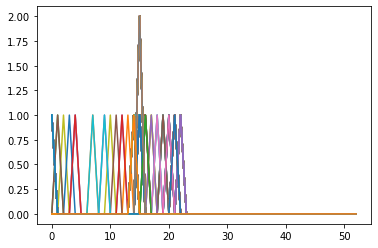

In [14]:
d = torch.empty( generated_gmm.size(0), 53 ) 
for i in range( 0, d.size(0) ) :
    d[i] = torch.histc( generated_gmm[i], min=0, max=5, bins=53 )
draw( d.t() )


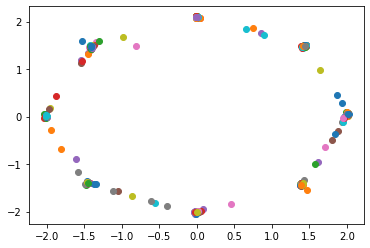

In [15]:
for i in range(0,512):
  x,y = generated_gmm[i]
  #print(x)
  #print(y)
  plt.scatter(x.cpu().detach().numpy() , y.cpu().detach().numpy())

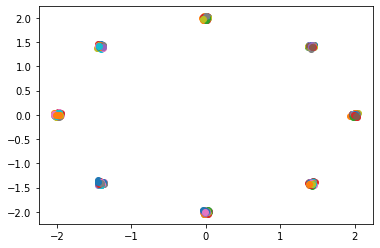

In [142]:
for i in range(0,512):
  x,y = gmm1.sample()
  #print(x)
  #print(y)
  plt.scatter(x.detach().numpy() , y.detach().numpy())

In [16]:
import torch


def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape),
                  torch.zeros(xx.shape),
                  torch.zeros(xx.shape))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)

In [17]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet 
from torch.distributions.multivariate_normal import MultivariateNormal 



x = gmm1.sample([512])
y = generated_gmm.cpu()

result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")

MMD result of X and Y is 0.05500953644514084
